In [8]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


In [37]:

input_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/Squats/incorrect-squat-side-view.mp4'
output_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/annotated_frames/af6'
coordinates_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/plots/co6'
output_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/pose_detection_yolo.mp4'

Load YOLO Model

In [10]:
net = cv2.dnn.readNet('/Users/suryanshpatel/Projects/Pose_detection/yolo/yolov3.weights', '/Users/suryanshpatel/Projects/Pose_detection/yolo/yolov3.cfg')
layer_names = net.getLayerNames()

# Adjust indexing to handle both cases where net.getUnconnectedOutLayers() returns a 1D or 2D array
try:
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [11]:
# Initialize MediaPipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

I0000 00:00:1718685835.419699 4554160 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2


In [12]:
class PoseLandmark:
    def __init__(self, x, y, visibility, box_dimensions):
        self._x = x
        self._y = y
        # self._z = z
        self._visibility = visibility
        self._box_dimensions = box_dimensions  # New field

    # Getters
    def get_x(self):
        return self._x

    def get_y(self):
        return self._y

    # def get_z(self):
    #     return self._z

    def get_visibility(self):
        return self._visibility

    def get_box_dimensions(self):
        return self._box_dimensions

    # Setters
    def set_x(self, x):
        self._x = x

    def set_y(self, y):
        self._y = y

    # def set_z(self, z):
    #     self._z = z

    def set_visibility(self, visibility):
        self._visibility = visibility

    def set_box_dimensions(self, box_dimensions):
        self._box_dimensions = box_dimensions

    # __str__ method for string representation
    def __str__(self):
        return (f"PoseLandmark(x={self._x}, y={self._y},  " #z={self._z} ,
                f"visibility={self._visibility}, box_dimensions={self._box_dimensions})")

    # Normalize joint coordinates based on bounding box dimensions
    def normalize(self):
        x, y, w, h = self._box_dimensions
        norm_x = (self._x - x) / w if w != 0 else 0
        norm_y = (self._y - y) / h if h != 0 else 0
        return PoseLandmark(norm_x, norm_y,  self._visibility, (0, 0, 1, 1))  # normalized box is (0,0,1,1)



Main driver Code

In [38]:
# Function to process a video and extract joint points and bounding box dimensions
def process_video(input_video_path, output_video_path, net, output_layers, pose):
    cap = cv2.VideoCapture(input_video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 files
    # output = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


    all_frame_data = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        # Track the best detection
        best_confidence = 0
        best_box = None

        # Get bounding box for the person with the highest confidence
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if class_id == 0 and confidence > best_confidence:  # Class 0 is for person
                    best_confidence = confidence
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = max(0, int(center_x - w / 2))
                    y = max(0, int(center_y - h / 2))
                    w = min(w, width - x)
                    h = min(h, height - y)
                    best_box = (x, y, w, h)

        if best_box:
            x, y, w, h = best_box

            # Extract the region within the bounding box
            roi = frame[y:y+h, x:x+w]

            if roi.size == 0:  # Check if the ROI is empty
                continue

            # Process the region with MediaPipe for pose estimation
            rgb_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)

            # Capture joint points
            single_frame_data = []
            if results.pose_landmarks:
                for landmark in results.pose_landmarks.landmark:
                    single_frame_data.append(PoseLandmark(landmark.x * w + x , landmark.y * h + y , landmark.visibility ,(x, y, w, h)))
                   
            #Surya - don't want to normalize now store as it is as we are storing box dimentions as well
            #  Normalize joint points within bounding box
            # normalized_points = normalize_joint_points_within_box(joint_points, (x, y, w, h))
            # all_joint_points.append(normalized_points)
        

            # Check if the number of joints detected is consistent
            if len(single_frame_data) == 33:  # Adjust 33 to your actual expected number of joints
                all_frame_data.append(single_frame_data)
            else:
                print(f"Skipping frame {len(all_frame_data) + 1} due to incomplete data: {len(single_frame_data)} joints")

            # Draw the bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Draw the pose annotation on the image
            if results.pose_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(roi, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

        # Write the frame to the output video
        # output.write(frame)

        # Optionally display the image
        cv2.imshow('Pose Detection', frame)
        if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
            break

    # Release resources
    cap.release()
    # output.release()
    cv2.destroyAllWindows()

    # Convert lists to NumPy arrays
    all_frame_data = np.array(all_frame_data, dtype=object)


    return all_frame_data


# Normalizes each frame data based on bounding box instead of frame
def normalize_frame_data(frame_data):
    normalized_data = []
    for frame in frame_data:
        normalized_frame = [landmark.normalize() for landmark in frame]
        normalized_data.append(normalized_frame)
    return np.array(normalized_data, dtype=object)



# Process the video
all_frame_data = process_video(input_video_path, output_video_path, net, output_layers, pose)

# Normalize the extracted data
normalized_data = normalize_frame_data(all_frame_data)

# Print shapes of extracted and normalized data
print("All frames object dimensions:", all_frame_data.shape)
print("Normalized frames object dimensions:", normalized_data.shape)


/Users/suryanshpatel/Projects/Pose_detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


All frames object dimensions: (197, 33)
Normalized frames object dimensions: (197, 33)


Compare some values from the original and normalized arrays.

:param original_data: List of lists of PoseLandmark objects (original data).
:param normalized_data: List of lists of PoseLandmark objects (normalized data).
:param num_samples: Number of samples to compare from each array.


In [27]:
def compare_landmark_values(original_data, normalized_data, num_samples=5):
 
    num_frames = min(len(original_data), len(normalized_data))

    print("Comparing some values from the original and normalized data:")
    for i in range(min(num_samples, num_frames)):
        print(f"\nFrame {i + 1}:")
        original_frame = original_data[i]
        normalized_frame = normalized_data[i]
        
        num_landmarks = min(len(original_frame), len(normalized_frame))
        for j in range(min(num_samples, num_landmarks)):
            original_landmark = original_frame[j]
            normalized_landmark = normalized_frame[j]

            print(f"  Landmark {j + 1}:")
            print(f"    Original: x={original_landmark.get_x()}, y={original_landmark.get_y()}, "
                  f"visibility={original_landmark.get_visibility()}")
            print(f"    Normalized: x={normalized_landmark.get_x()}, y={normalized_landmark.get_y()}, "
                  f"visibility={normalized_landmark.get_visibility()}")


# Example usage
compare_landmark_values(all_frame_data, normalized_data, num_samples=5)


Comparing some values from the original and normalized data:

Frame 1:
  Landmark 1:
    Original: x=143.262925863266, y=303.7182080745697, visibility=0.9986487030982971
    Normalized: x=0.5560911297798157, y=0.7384898066520691, visibility=0.9986487030982971
  Landmark 2:
    Original: x=145.02728819847107, y=300.37233543395996, visibility=0.9988598823547363
    Normalized: x=0.579306423664093, y=0.7294955253601074, visibility=0.9988598823547363
  Landmark 3:
    Original: x=150.88540530204773, y=307.55228424072266, visibility=0.9989231824874878
    Normalized: x=0.6563869118690491, y=0.7487964630126953, visibility=0.9989231824874878
  Landmark 4:
    Original: x=148.66796612739563, y=307.823614358902, visibility=0.9988086223602295
    Normalized: x=0.6272100806236267, y=0.7495258450508118, visibility=0.9988086223602295
  Landmark 5:
    Original: x=158.87602043151855, y=310.69835662841797, visibility=0.9985511898994446
    Normalized: x=0.7615265846252441, y=0.7572536468505859, visib

Plots for each joints

plot every joint and print trejectory

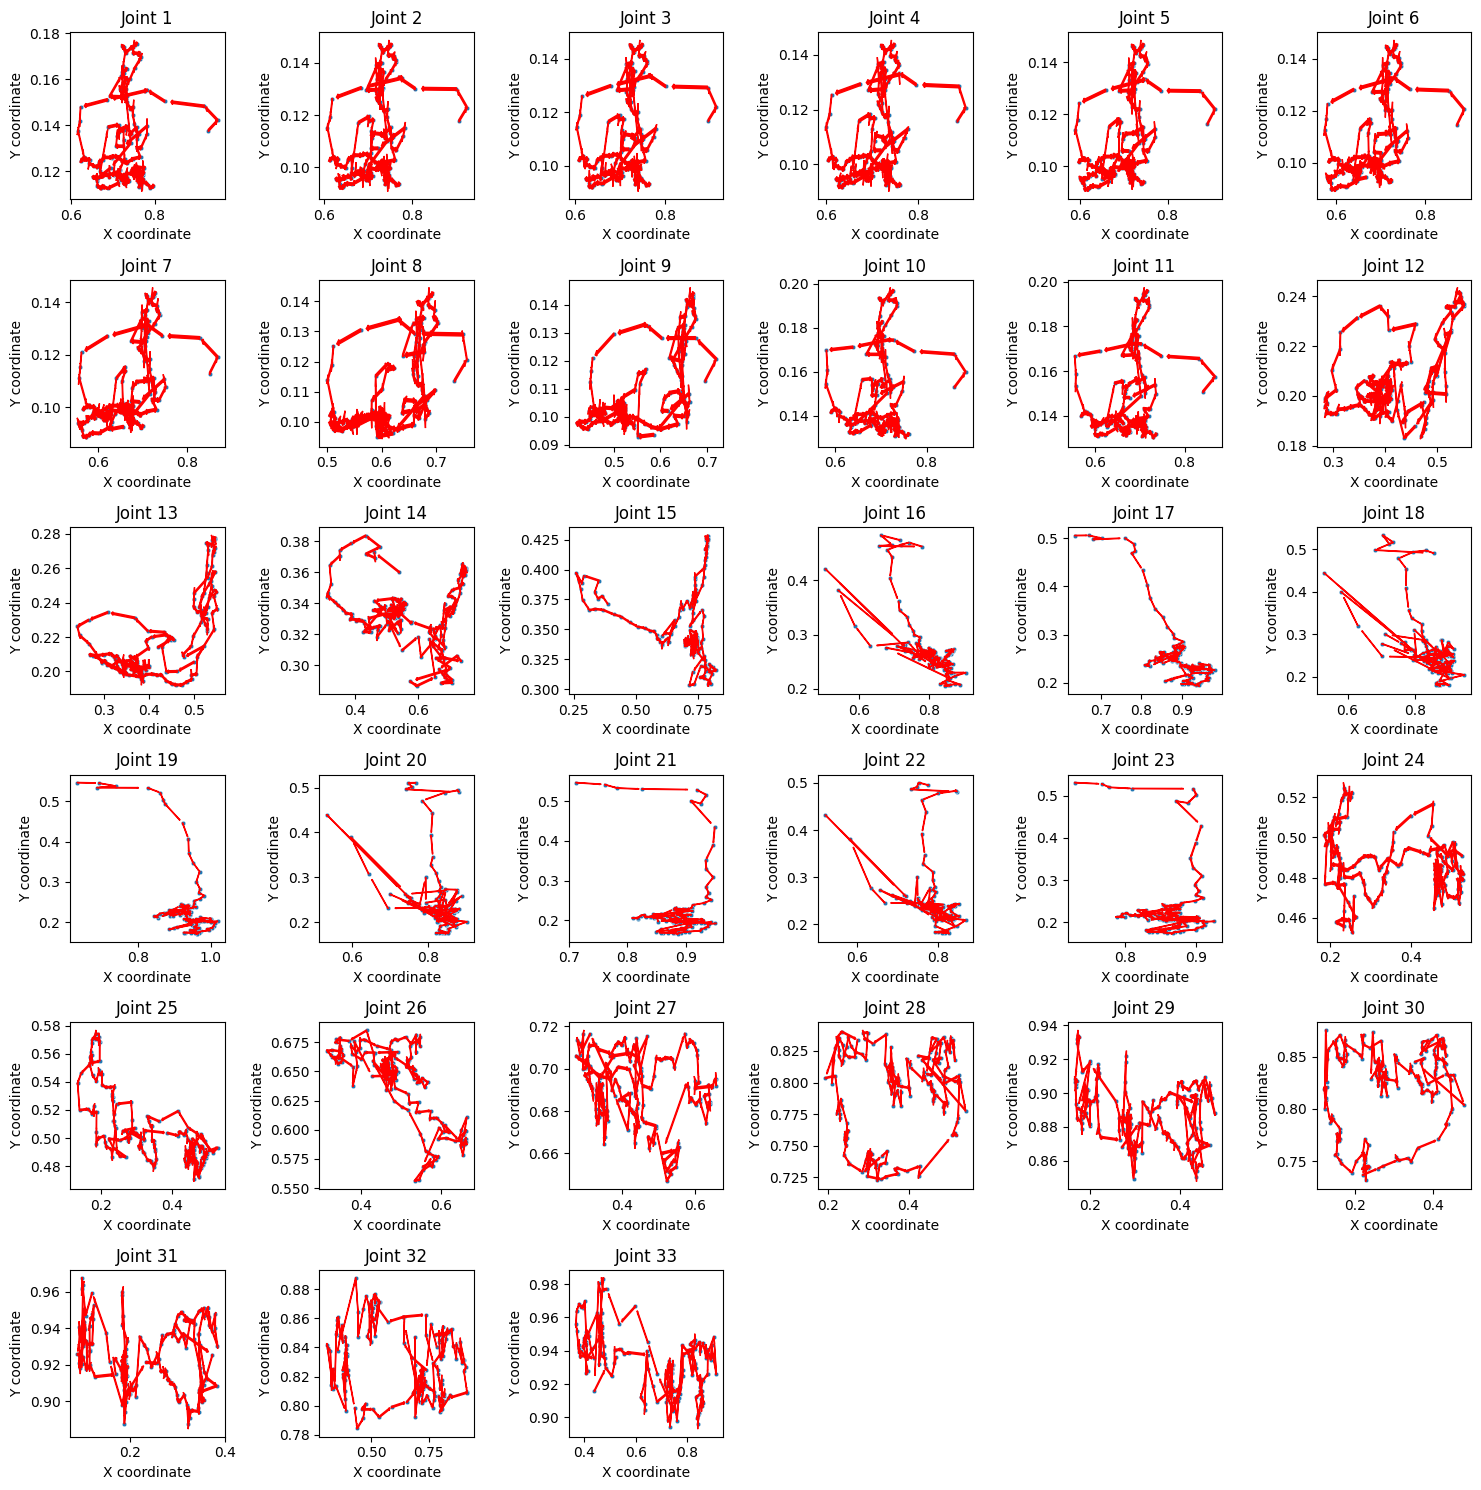

In [39]:


# Example function to extract data from all_frame_data
def extract_joint_data(all_frame_data):
    num_frames = all_frame_data.shape[0]
    num_joints = len(all_frame_data[0])  # Assuming all frames have the same number of joints
    
    # Initialize lists to store joint coordinates across frames
    joint_x = [[] for _ in range(num_joints)]
    joint_y = [[] for _ in range(num_joints)]
    
    # Iterate through each frame and each joint to extract coordinates
    for frame_idx in range(num_frames):
        frame = all_frame_data[frame_idx]
        for joint_idx in range(num_joints):
            landmark = frame[joint_idx]
            joint_x[joint_idx].append(landmark.get_x())  # Replace with actual method to get x coordinate
            joint_y[joint_idx].append(landmark.get_y())  # Replace with actual method to get y coordinate
    
    # Convert lists to NumPy arrays for plotting convenience
    joint_x = np.array(joint_x)
    joint_y = np.array(joint_y)
    
    return joint_x, joint_y

# Example usage
joint_x, joint_y = extract_joint_data(normalized_data)

# Plotting pair plot for all joints with arrows between consecutive frames
num_joints = joint_x.shape[0]
plt.figure(figsize=(15, 15))
for i in range(num_joints):
    plt.subplot(6, 6, i + 1)
    
    # Scatter plot with arrows between consecutive frames
    sns.scatterplot(x=joint_x[i], y=joint_y[i], marker='o', s=10)
    for j in range(len(joint_x[i]) - 1):
        dx = joint_x[i][j + 1] - joint_x[i][j]
        dy = joint_y[i][j + 1] - joint_y[i][j]
        plt.arrow(joint_x[i][j], joint_y[i][j], dx * 0.8, dy * 0.8, color='r', head_width=0.002, head_length=0.004)
    
    plt.title(f'Joint {i + 1}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
plt.tight_layout()
plt.show()


animation not working

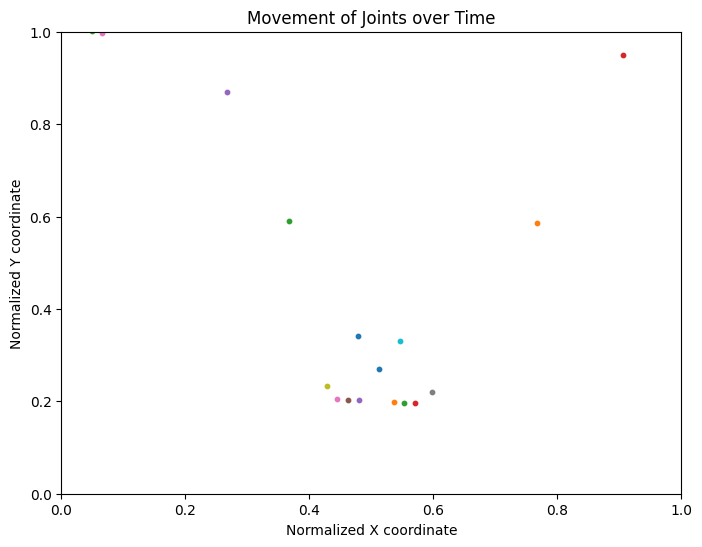

In [16]:


# Function to prepare data for animation
def prepare_data_for_animation(normalized_data):
    num_frames = normalized_data.shape[0]
    num_joints = len(normalized_data[0])  # Assuming all frames have the same number of joints
    
    # Initialize lists to store normalized joint coordinates across frames
    joint_x_normalized = [[] for _ in range(num_joints)]
    joint_y_normalized = [[] for _ in range(num_joints)]
    
    # Iterate through each frame and each joint to extract normalized coordinates
    for frame_idx in range(num_frames):
        frame = normalized_data[frame_idx]
        for joint_idx in range(num_joints):
            landmark = frame[joint_idx]
            norm_x = landmark.get_x()  # Replace with actual method to get normalized x coordinate
            norm_y = landmark.get_y()  # Replace with actual method to get normalized y coordinate
            joint_x_normalized[joint_idx].append(norm_x)
            joint_y_normalized[joint_idx].append(norm_y)
    
    # Convert lists to NumPy arrays for plotting convenience
    joint_x_normalized = np.array(joint_x_normalized)
    joint_y_normalized = np.array(joint_y_normalized)
    
    return joint_x_normalized, joint_y_normalized

# Example function to update frames in animation
def update_frame(frame_idx, data, scatters):
    for i in range(len(scatters)):
        scatters[i].set_offsets(np.c_[data[0][i][frame_idx], data[1][i][frame_idx]])
    return scatters

# Example usage with normalized data
joint_x_normalized, joint_y_normalized = prepare_data_for_animation(normalized_data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize scatter plot with empty data
scatters = [ax.scatter([], [], s=10) for _ in range(len(joint_x_normalized))]

# Set axis limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Normalized X coordinate')
ax.set_ylabel('Normalized Y coordinate')

# Animation function
ani = animation.FuncAnimation(fig, update_frame, frames=len(joint_x_normalized[0]), fargs=((joint_x_normalized, joint_y_normalized), scatters), interval=50, blit=True)

plt.title('Movement of Joints over Time')
plt.show()
